In [1]:
import sys


# Comando para instalar (mais robusto)
!{sys.executable} -m pip install "mlflow<2.0"


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install pycaret

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install pycaret pandas matplotlib seaborn
!pip install shap


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\paulo\anaconda3\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\paulo\anaconda3\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import json

# --- Caminhos dos arquivos (ajuste se necessário) ---
caminho_dataset_principal = r'dataset_tratado\dataset_enriquecido_20250930_120011.csv'
caminho_json_ia = r'dataset_tratado\dados_extraidos_ia.json'
caminho_precos_hp = r'fornecidos_pela_hp\Tabela de Preços Sugeridos.csv'

# --- Carregamento ---
try:
    # 1. Dataset principal
    df_principal = pd.read_csv(caminho_dataset_principal)
    print(f"Dataset principal carregado com sucesso. Formato: {df_principal.shape}")

    # 2. Dados extraídos pela IA (JSON)
    with open(caminho_json_ia, 'r', encoding='utf-8') as f:
        dados_ia_lista = json.load(f)
    df_ia = pd.DataFrame(dados_ia_lista)
    print(f"Dados da IA (JSON) carregados com sucesso. Formato: {df_ia.shape}")

    # 3. Tabela de preços da HP
    df_precos_hp = pd.read_csv(caminho_precos_hp, sep=';')
    print(f"Tabela de preços HP carregada com sucesso. Formato: {df_precos_hp.shape}")

except FileNotFoundError as e:
    print(f"Erro ao carregar o arquivo: {e}. Verifique se os caminhos estão corretos.")

# Visualizar as primeiras linhas de cada dataframe para garantir que tudo está certo
print("\n--- Amostra do Dataset Principal ---")
print(df_principal.head(3))
print("\n--- Amostra dos Dados da IA ---")
print(df_ia.head(3))
print("\n--- Amostra da Tabela de Preços HP ---")
print(df_precos_hp.head(3))

Dataset principal carregado com sucesso. Formato: (453, 37)
Dados da IA (JSON) carregados com sucesso. Formato: (453, 5)
Tabela de preços HP carregada com sucesso. Formato: (36, 5)

--- Amostra do Dataset Principal ---
    id_produto                                             titulo  \
0  MLB36751629   Cartucho de tinta preta HP Advantage 664 de 2 ml   
1  MLB37141763         Cartucho De Tinta Hp 667 Cor Preto Do 2 Ml   
2  MLB36751072  Kit Cartucho Hp 664 Preto E Hp 664 Colorido | ...   

                                                link  preco_atual  \
0  https://www.mercadolivre.com.br/cartucho-de-ti...        65.73   
1  https://www.mercadolivre.com.br/cartucho-de-ti...        71.36   
2  https://www.mercadolivre.com.br/kit-cartucho-h...       143.90   

   preco_original  unidades_por_anuncio  preco_por_unidade condicao  \
0            78.8                     1              65.73     Novo   
1             NaN                     1              71.36     Novo   
2             

Limpeza e Padronização da Tabela de Preços

In [5]:
# Renomear colunas para um padrão mais fácil de usar
df_precos_hp.rename(columns={
    'Produto': 'produto_hp',
    'Preco Sugerido': 'preco_sugerido_hp'
}, inplace=True)

# Limpar e padronizar a coluna 'produto_hp' para servir como chave de junção
# Ex: 'Cartucho HP 667 Preto' -> 'cartucho hp 667 preto'
df_precos_hp['chave_produto'] = df_precos_hp['produto_hp'].str.lower().str.strip()

# --- CORREÇÃO APLICADA AQUI ---
# Apenas garantimos que a coluna é do tipo numérico (float).
# O pandas já deve ter lido corretamente como número.
# Se ainda estivesse como texto (com vírgula), precisaríamos de um tratamento diferente,
# mas o erro mostra que já é numérico.
df_precos_hp['preco_sugerido_hp'] = pd.to_numeric(df_precos_hp['preco_sugerido_hp'], errors='coerce')


print("Tabela de preços HP após padronização:")
print(df_precos_hp.head())
print("\nTipos de dados da tabela de preços:")
print(df_precos_hp.info())


Tabela de preços HP após padronização:
        PN Familia                  produto_hp Media de Paginas Impressas  \
0  3YM78AB  HP 667    Cartucho HP 667 Colorido                        100   
1  3YM79AB  HP 667       Cartucho HP 667 Preto                        120   
2  3YM80AB  HP 667  Cartucho HP 667XL Colorido                        330   
3  3YM81AB  HP 667     Cartucho HP 667XL Preto                        480   
4  F6V28AB  HP 664             HP 664 Colorido                        100   

   preco_sugerido_hp               chave_produto  
0               74.9    cartucho hp 667 colorido  
1               69.9       cartucho hp 667 preto  
2              172.9  cartucho hp 667xl colorido  
3              172.9     cartucho hp 667xl preto  
4               74.9             hp 664 colorido  

Tipos de dados da tabela de preços:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtyp

Fusão do Dataset Principal com os Dados da IA

In [6]:
# --- PASSO 1: PADRONIZAR NOMES DE COLUNAS NO DF_IA ---
# O diagnóstico mostrou que a coluna se chama 'cores_detalhadas'. Vamos renomeá-la para 'cor'.
try:
    df_ia.rename(columns={
        'cores_detalhadas': 'cor', # <-- A CORREÇÃO PRINCIPAL ESTÁ AQUI
        'quantidade_por_anuncio': 'unidades_por_anuncio_ia' 
    }, inplace=True)
    print("Colunas do df_ia renomeadas com sucesso para o padrão ('cor' e 'unidades_por_anuncio_ia').")
except Exception as e:
    print(f"AVISO: Ocorreu um erro ao renomear as colunas: {e}")


# --- PASSO 2: FAZER O MERGE ---
# O merge será feito usando 'id_produto' como chave.
df_merged = pd.merge(df_principal, df_ia, on='id_produto', how='left')


# --- PASSO 3: ATUALIZAR OS DADOS (FONTE DA VERDADE = IA) ---
# Substituímos a coluna de unidades do dataset original pela da IA, quando disponível.
if 'unidades_por_anuncio_ia' in df_merged.columns:
    df_merged['unidades_por_anuncio'] = df_merged['unidades_por_anuncio_ia'].fillna(df_merged['unidades_por_anuncio'])
    # Remove a coluna auxiliar que veio da IA
    df_merged.drop(columns=['unidades_por_anuncio_ia'], inplace=True)


# --- PASSO 4: VERIFICAÇÃO FINAL ---
print("\n--- Verificação Final do Dataset Após Fusão ---")
colunas_para_verificar = ['id_produto', 'unidades_por_anuncio', 'cor', 'tipo_cartucho']
colunas_existentes = [col for col in colunas_para_verificar if col in df_merged.columns]

if len(colunas_existentes) == len(colunas_para_verificar):
    print("\nSUCESSO! Todas as colunas foram fundidas corretamente.")
else:
    print("\nERRO: Algumas colunas ainda estão faltando. Verifique o passo de renomear.")

print(f"\nMostrando as colunas existentes: {colunas_existentes}")
print(df_merged[colunas_existentes].head())

Colunas do df_ia renomeadas com sucesso para o padrão ('cor' e 'unidades_por_anuncio_ia').

--- Verificação Final do Dataset Após Fusão ---

SUCESSO! Todas as colunas foram fundidas corretamente.

Mostrando as colunas existentes: ['id_produto', 'unidades_por_anuncio', 'cor', 'tipo_cartucho']
    id_produto  unidades_por_anuncio                          cor  \
0  MLB36751629                     1  {'preto': 1, 'colorido': 0}   
1  MLB37141763                     1  {'preto': 1, 'colorido': 0}   
2  MLB37141763                     1  {'preto': 1, 'colorido': 0}   
3  MLB36751072                     2  {'preto': 1, 'colorido': 1}   
4  MLB36751072                     2  {'preto': 1, 'colorido': 1}   

  tipo_cartucho  
0           664  
1           667  
2           667  
3           664  
4           664  


In [7]:
# Este comando vai listar os nomes exatos das colunas no seu dataframe da IA
print(df_ia.columns)

Index(['id_produto', 'unidades_por_anuncio_ia', 'cor', 'tipo_cartucho',
       'usado_seminovo'],
      dtype='object')


In [8]:
import numpy as np
import re

def buscar_preco_sugerido_robusta(row, df_precos):
    # Retorna nulo se a informação essencial não foi extraída pela IA
    if pd.isna(row['tipo_cartucho']) or pd.isna(row['cor']):
        return np.nan

    # --- 1. Padronização das Entradas ---
    # Garante que tanto 'cor' quanto 'tipo_cartucho' sejam listas de strings
    
    # Padroniza 'cor'
    cores_raw = row['cor']
    if isinstance(cores_raw, str):
        cores = [c.strip() for c in cores_raw.split(',')]
    elif isinstance(cores_raw, list):
        cores = cores_raw
    else: # Caso seja um número ou outro tipo, não podemos processar
        return np.nan

    # Padroniza 'tipo_cartucho'
    tipos_raw = row['tipo_cartucho']
    if isinstance(tipos_raw, str):
        # Usa regex para tratar espaços extras: '664, 664' -> ['664', '664']
        tipos = [t.strip() for t in re.split(r'\s*,\s*', tipos_raw)]
    elif isinstance(tipos_raw, list):
        tipos = tipos_raw
    else: # Converte para string caso seja um número (ex: 664)
        tipos = [str(tipos_raw)]

    # --- 2. Validação da Consistência ---
    # Em um combo, o número de tipos deve ser igual ao número de cores
    if len(cores) != len(tipos) and len(cores) > 1:
        # Permite exceção se for um tipo para várias cores (ex: 664xl para [preto, colorido])
        if len(tipos) == 1:
            tipos = tipos * len(cores) # Repete o tipo para cada cor
        else:
            return np.nan # Dados inconsistentes, não podemos calcular

    preco_total_sugerido = 0

    # --- 3. Lógica de Cálculo ---
    
    # CASO A: Anúncio de item único (mesmo que em multipack de itens idênticos)
    if len(cores) == 1:
        cor_unica = 'tri-color' if cores[0].lower() == 'colorido' else cores[0].lower()
        tipo_unico = tipos[0].lower()
        
        # Constrói a chave de busca
        if 'cartucho' not in tipo_unico and 'hp' not in tipo_unico:
            chave_busca = f"hp {tipo_unico} {cor_unica}"
        else:
            chave_busca = f"{tipo_unico} {cor_unica}"
        
        match = df_precos[df_precos['chave_produto'].str.contains(chave_busca, na=False)]
        
        if not match.empty:
            preco_unitario = match['preco_sugerido_hp'].iloc[0]
            unidades = row['unidades_por_anuncio'] if pd.notna(row['unidades_por_anuncio']) else 1
            preco_total_sugerido = preco_unitario * unidades
        else:
            return np.nan
            
    # CASO B: Anúncio de combo com itens diferentes
    else:
        # Itera sobre cada par de tipo e cor
        for tipo, cor in zip(tipos, cores):
            cor_ajustada = 'tri-color' if cor.lower() == 'colorido' else cor.lower()
            tipo_ajustado = tipo.lower()
            
            # Constrói a chave de busca para cada item do combo
            if 'cartucho' not in tipo_ajustado and 'hp' not in tipo_ajustado:
                chave_busca = f"hp {tipo_ajustado} {cor_ajustada}"
            else:
                chave_busca = f"{tipo_ajustado} {cor_ajustada}"
            
            match = df_precos[df_precos['chave_produto'].str.contains(chave_busca, na=False)]
            
            if not match.empty:
                preco_total_sugerido += match['preco_sugerido_hp'].iloc[0]
            else:
                # Se um item do combo não for encontrado, o preço total é inválido
                return np.nan

    return preco_total_sugerido if preco_total_sugerido > 0 else np.nan

# --- Aplicação da Nova Função ---

# Aplicar a função para criar a coluna 'preco_sugerido_total_anuncio'
df_merged['preco_sugerido_total_anuncio'] = df_merged.apply(buscar_preco_sugerido_robusta, args=(df_precos_hp,), axis=1)

# Calcular a diferença percentual
# Fórmula: (Preço Atual - Preço Sugerido) / Preço Sugerido
df_merged['diferenca_preco_perc'] = (df_merged['preco_atual'] - df_merged['preco_sugerido_total_anuncio']) / df_merged['preco_sugerido_total_anuncio']

# Visualizar o resultado para verificação
print("\nDataset com Preço Sugerido e Diferença Percentual (Lógica Robusta):")
print(df_merged[[
    'id_produto', 'preco_atual', 'unidades_por_anuncio', 'cor', 'tipo_cartucho', 
    'preco_sugerido_total_anuncio', 'diferenca_preco_perc'
]].head(10))

# Verificar quantos valores não conseguimos calcular
print(f"\nTotal de anúncios: {len(df_merged)}")
print(f"Anúncios sem preço sugerido calculado: {df_merged['preco_sugerido_total_anuncio'].isna().sum()}")


Dataset com Preço Sugerido e Diferença Percentual (Lógica Robusta):
    id_produto  preco_atual  unidades_por_anuncio  \
0  MLB36751629        65.73                     1   
1  MLB37141763        71.36                     1   
2  MLB37141763        71.36                     1   
3  MLB36751072       143.90                     2   
4  MLB36751072       143.90                     2   
5  MLB36752265        61.96                     1   
6  MLB36752265        61.96                     1   
7  MLB48102366       295.67                     2   
8  MLB43544566       121.40                     1   
9  MLB43544566       121.40                     1   

                           cor tipo_cartucho  preco_sugerido_total_anuncio  \
0  {'preto': 1, 'colorido': 0}           664                           NaN   
1  {'preto': 1, 'colorido': 0}           667                           NaN   
2  {'preto': 1, 'colorido': 0}           667                           NaN   
3  {'preto': 1, 'colorido': 1}     

Correção do Formato da Coluna 'cor'

In [9]:
import ast

def converter_cor_para_lista(cor_data):
    # Tenta avaliar se o dado é uma string de dicionário/lista (ex: "{'preto': 1}")
    if isinstance(cor_data, str):
        try:
            cor_data = ast.literal_eval(cor_data)
        except (ValueError, SyntaxError):
            return cor_data # Se não for um formato conhecido, retorna o original

    # Se o dado for um dicionário, converte para lista
    if isinstance(cor_data, dict):
        lista_cores = []
        if cor_data.get('preto') == 1:
            lista_cores.append('Preto')
        if cor_data.get('colorido') == 1:
            lista_cores.append('Colorido')
        return lista_cores
    
    # Se já for uma lista ou outro formato, retorna como está
    return cor_data

# --- Aplicação da Função de Correção ---
# Aplicamos a função na coluna 'cor' do nosso dataframe
df_merged['cor'] = df_merged['cor'].apply(converter_cor_para_lista)

print("--- Formato da coluna 'cor' após a correção ---")
print(df_merged[['id_produto', 'cor', 'tipo_cartucho']].head())

--- Formato da coluna 'cor' após a correção ---
    id_produto                cor tipo_cartucho
0  MLB36751629            [Preto]           664
1  MLB37141763            [Preto]           667
2  MLB37141763            [Preto]           667
3  MLB36751072  [Preto, Colorido]           664
4  MLB36751072  [Preto, Colorido]           664


In [10]:
import numpy as np
import re

def buscar_preco_sugerido_robusta(row, df_precos):
    # --- CORREÇÃO APLICADA AQUI ---
    # Verificamos se 'tipo_cartucho' é nulo OU se a lista 'cor' está vazia/nula
    if pd.isna(row['tipo_cartucho']) or not row['cor']:
        return np.nan

    # --- 1. Padronização das Entradas ---
    cores_raw = row['cor']
    if isinstance(cores_raw, str):
        cores = [c.strip() for c in cores_raw.split(',')]
    elif isinstance(cores_raw, list):
        cores = cores_raw
    else:
        return np.nan

    tipos_raw = row['tipo_cartucho']
    if isinstance(tipos_raw, str):
        tipos = [t.strip() for t in re.split(r'\s*,\s*', tipos_raw)]
    elif isinstance(tipos_raw, list):
        tipos = tipos_raw
    else:
        tipos = [str(tipos_raw)]

    # --- 2. Validação da Consistência ---
    if len(cores) != len(tipos) and len(cores) > 1:
        if len(tipos) == 1:
            tipos = tipos * len(cores)
        else:
            return np.nan

    preco_total_sugerido = 0

    # --- 3. Lógica de Cálculo ---
    if len(cores) == 1:
        cor_unica = 'tri-color' if cores[0].lower() == 'colorido' else cores[0].lower()
        tipo_unico = tipos[0].lower()
        
        if 'cartucho' not in tipo_unico and 'hp' not in tipo_unico:
            chave_busca = f"hp {tipo_unico} {cor_unica}"
        else:
            chave_busca = f"{tipo_unico} {cor_unica}"
        
        match = df_precos[df_precos['chave_produto'].str.contains(chave_busca, na=False)]
        
        if not match.empty:
            preco_unitario = match['preco_sugerido_hp'].iloc[0]
            # Garantimos que 'unidades_por_anuncio' seja um número para a multiplicação
            unidades = pd.to_numeric(row['unidades_por_anuncio'], errors='coerce')
            unidades = 1 if pd.isna(unidades) else unidades
            preco_total_sugerido = preco_unitario * unidades
        else:
            return np.nan
            
    else:
        for tipo, cor in zip(tipos, cores):
            cor_ajustada = 'tri-color' if cor.lower() == 'colorido' else cor.lower()
            tipo_ajustado = tipo.lower()
            
            if 'cartucho' not in tipo_ajustado and 'hp' not in tipo_ajustado:
                chave_busca = f"hp {tipo_ajustado} {cor_ajustada}"
            else:
                chave_busca = f"{tipo_ajustado} {cor_ajustada}"
            
            match = df_precos[df_precos['chave_produto'].str.contains(chave_busca, na=False)]
            
            if not match.empty:
                preco_total_sugerido += match['preco_sugerido_hp'].iloc[0]
            else:
                return np.nan

    return preco_total_sugerido if preco_total_sugerido > 0 else np.nan

# --- Aplicação da Nova Função ---
df_merged['preco_sugerido_total_anuncio'] = df_merged.apply(buscar_preco_sugerido_robusta, args=(df_precos_hp,), axis=1)
df_merged['diferenca_preco_perc'] = (df_merged['preco_atual'] - df_merged['preco_sugerido_total_anuncio']) / df_merged['preco_sugerido_total_anuncio']

# Visualizar o resultado para verificação
print("\nDataset com Preço Sugerido e Diferença Percentual (Lógica Robusta):")
print(df_merged[[
    'id_produto', 'preco_atual', 'unidades_por_anuncio', 'cor', 'tipo_cartucho', 
    'preco_sugerido_total_anuncio', 'diferenca_preco_perc'
]].head(10))

# Verificar quantos valores não conseguimos calcular
print(f"\nTotal de anúncios: {len(df_merged)}")
print(f"Anúncios sem preço sugerido calculado: {df_merged['preco_sugerido_total_anuncio'].isna().sum()}")


Dataset com Preço Sugerido e Diferença Percentual (Lógica Robusta):
    id_produto  preco_atual  unidades_por_anuncio                cor  \
0  MLB36751629        65.73                     1            [Preto]   
1  MLB37141763        71.36                     1            [Preto]   
2  MLB37141763        71.36                     1            [Preto]   
3  MLB36751072       143.90                     2  [Preto, Colorido]   
4  MLB36751072       143.90                     2  [Preto, Colorido]   
5  MLB36752265        61.96                     1         [Colorido]   
6  MLB36752265        61.96                     1         [Colorido]   
7  MLB48102366       295.67                     2  [Preto, Colorido]   
8  MLB43544566       121.40                     1            [Preto]   
9  MLB43544566       121.40                     1            [Preto]   

  tipo_cartucho  preco_sugerido_total_anuncio  diferenca_preco_perc  
0           664                          69.9             -0.059657 

Verificar os anuncios que não deram preço sugerido

In [11]:
# --- 1. Contagem de todos os tipos de cartucho no DataFrame completo ---
print("--- Contagem Geral de 'tipo_cartucho' em todo o dataset ---")
contagem_geral = df_merged['tipo_cartucho'].value_counts(dropna=False)
print(contagem_geral)
print("\n" + "="*50 + "\n")


# --- 2. Análise dos tipos de cartucho que não foram encontrados na tabela de preços ---
print("--- Análise dos 'tipo_cartucho' para os quais o preço não foi calculado ---")

# Criamos um DataFrame temporário apenas com os anúncios onde o cálculo falhou
df_nao_calculados = df_merged[df_merged['preco_sugerido_total_anuncio'].isna()]

if df_nao_calculados.empty:
    print("Ótima notícia! Todos os anúncios tiveram seus preços calculados.")
else:
    # Contamos a frequência de cada 'tipo_cartucho' neste grupo filtrado
    contagem_nao_calculados = df_nao_calculados['tipo_cartucho'].value_counts(dropna=False)
    print("Contagem dos tipos de cartucho que falharam no cálculo de preço:")
    print(contagem_nao_calculados)

--- Contagem Geral de 'tipo_cartucho' em todo o dataset ---
667                                         156
664                                         141
664xl                                        78
667xl                                        62
662                                           6
664, 664                                      4
HP 664XL                                      3
HP 667                                        3
664, 664xl                                    3
664,664xl                                     2
667XL                                         2
C6658AL |HP 58 | C6658 | 6658AL |C6658AB      1
HP 667XL                                      1
980                                           1
667, 667                                      1
                                              1
3YM78AL                                       1
3ym81al                                       1
667, 667xl                                    1
3YM78AB                     

In [12]:
import re

def limpar_e_extrair_tipo(tipo):
    """
    Inspeciona uma string de 'tipo_cartucho', extrai as partes válidas 
    (664, 667, 664xl, 667xl) e retorna uma string limpa.
    Retorna None se nenhuma parte válida for encontrada.
    """
    if not isinstance(tipo, str):
        return None

    # A ordem é importante: procurar por '664xl' antes de '664' para evitar correspondências erradas.
    tipos_validos = ['664xl', '667xl', '664', '667']
    
    partes_encontradas = []
    
    # Deixa a string em minúsculas para uma busca case-insensitive
    tipo_lower = tipo.lower()

    for valido in tipos_validos:
        # Encontra todas as ocorrências do tipo válido na string
        # Usamos uma expressão regular simples para encontrar a palavra exata
        matches = re.findall(r'\b' + re.escape(valido) + r'\b', tipo_lower)
        if matches:
            partes_encontradas.extend(matches)
            # Remove a parte encontrada para não ser encontrada novamente por um tipo mais simples (ex: 664 em 664xl)
            tipo_lower = tipo_lower.replace(valido, '')
            
    if not partes_encontradas:
        return None  # Nenhum tipo válido encontrado
    else:
        # Retorna as partes encontradas, unidas por vírgula
        return ', '.join(sorted(list(set(partes_encontradas))))

# --- Aplicação da Limpeza ---

print(f"Formato do DataFrame ANTES da limpeza: {df_merged.shape}")

# 1. Aplica a função para criar uma nova coluna limpa
df_merged['tipo_cartucho_limpo'] = df_merged['tipo_cartucho'].apply(limpar_e_extrair_tipo)

# 2. Remove as linhas onde nenhum tipo válido foi encontrado (a função retornou None)
df_merged.dropna(subset=['tipo_cartucho_limpo'], inplace=True)

# 3. Substitui a coluna original pela coluna limpa e remove a coluna temporária
df_merged['tipo_cartucho'] = df_merged['tipo_cartucho_limpo']
df_merged.drop(columns=['tipo_cartucho_limpo'], inplace=True)

# Garante que o índice do dataframe seja resetado após a remoção de linhas
df_merged.reset_index(drop=True, inplace=True)

print(f"Formato do DataFrame DEPOIS da limpeza: {df_merged.shape}")
print("\n--- Amostra da coluna 'tipo_cartucho' após a limpeza ---")
print(df_merged['tipo_cartucho'].value_counts())

Formato do DataFrame ANTES da limpeza: (491, 42)
Formato do DataFrame DEPOIS da limpeza: (466, 42)

--- Amostra da coluna 'tipo_cartucho' após a limpeza ---
667           160
664           147
664xl          85
667xl          67
664, 664xl      6
667, 667xl      1
Name: tipo_cartucho, dtype: int64


 Isolar e Inspecionar os Casos de Falha

In [13]:
# --- Caminho do arquivo (verifique se está correto) ---
caminho_precos_hp = r'fornecidos_pela_hp\Tabela de Preços Sugeridos.csv'

# --- Recarregando e preparando o CSV ---
try:
    df_precos_hp = pd.read_csv(caminho_precos_hp, sep=';')
    
    df_precos_hp.rename(columns={
        'Produto': 'produto_hp',
        'Preco Sugerido': 'preco_sugerido_hp'
    }, inplace=True)

    df_precos_hp['chave_produto'] = df_precos_hp['produto_hp'].str.lower().str.strip()
    df_precos_hp['preco_sugerido_hp'] = pd.to_numeric(df_precos_hp['preco_sugerido_hp'], errors='coerce')

    print("--- Tabela de Preços HP ATUALIZADA e Padronizada foi carregada com sucesso! ---")
    print(df_precos_hp.head())

except FileNotFoundError as e:
    print(f"Erro: {e}. Verifique o caminho do arquivo da tabela de preços.")

--- Tabela de Preços HP ATUALIZADA e Padronizada foi carregada com sucesso! ---
        PN Familia                  produto_hp Media de Paginas Impressas  \
0  3YM78AB  HP 667    Cartucho HP 667 Colorido                        100   
1  3YM79AB  HP 667       Cartucho HP 667 Preto                        120   
2  3YM80AB  HP 667  Cartucho HP 667XL Colorido                        330   
3  3YM81AB  HP 667     Cartucho HP 667XL Preto                        480   
4  F6V28AB  HP 664             HP 664 Colorido                        100   

   preco_sugerido_hp               chave_produto  
0               74.9    cartucho hp 667 colorido  
1               69.9       cartucho hp 667 preto  
2              172.9  cartucho hp 667xl colorido  
3              172.9     cartucho hp 667xl preto  
4               74.9             hp 664 colorido  


In [14]:
import numpy as np
import re

# Versão 6 (Simplificada) - Para o CSV padronizado
def buscar_preco_sugerido_simplificada(row, df_precos):
    
    cores_raw = row['cor']
    titulo = str(row['titulo']).lower()

    if not cores_raw:
        cores_inferidas = []
        if 'preto' in titulo or 'black' in titulo: cores_inferidas.append('Preto')
        if 'colorido' in titulo or 'color' in titulo or 'tri-color' in titulo: cores_inferidas.append('Colorido')
        cores_raw = cores_inferidas if cores_inferidas else []
    
    if not cores_raw: return np.nan

    cores = cores_raw if isinstance(cores_raw, list) else [c.strip() for c in cores_raw.split(',')]
    tipos = [t.strip() for t in re.split(r'\s*,\s*', str(row['tipo_cartucho']))]

    if len(cores) != len(tipos) and len(cores) > 1 and len(tipos) == 1:
        tipos = tipos * len(cores)

    preco_total_sugerido = 0
    
    # --- LÓGICA DE BUSCA SIMPLIFICADA ---
    for tipo, cor in zip(tipos, cores):
        tipo_ajustado = tipo.lower()
        # Agora a busca é direta, pois o CSV só tem "colorido"
        cor_ajustada = cor.lower()
        
        chave_busca = f"hp {tipo_ajustado} {cor_ajustada}"
        match = df_precos[df_precos['chave_produto'].str.contains(chave_busca, na=False)]
        
        if not match.empty:
            preco_total_sugerido += match['preco_sugerido_hp'].iloc[0]
        else:
            return np.nan

    # Lógica para multiplicar pela quantidade (ex: 2 cartuchos pretos)
    unidades = pd.to_numeric(row['unidades_por_anuncio'], errors='coerce')
    unidades = 1 if pd.isna(unidades) else unidades
    if len(set(tipos)) == 1 and len(set(cores)) == 1 and unidades > 1:
         preco_total_sugerido *= unidades

    return preco_total_sugerido if preco_total_sugerido > 0 else np.nan

print("Função de busca simplificada ('buscar_preco_sugerido_simplificada') foi definida.")

Função de busca simplificada ('buscar_preco_sugerido_simplificada') foi definida.


In [15]:
# --- Re-execução do Cálculo com a Função SIMPLIFICADA ---
print("Aplicando a função SIMPLIFICADA com a tabela de preços correta...")
df_merged['preco_sugerido_total_anuncio'] = df_merged.apply(buscar_preco_sugerido_simplificada, args=(df_precos_hp,), axis=1)
df_merged['diferenca_preco_perc'] = (df_merged['preco_atual'] - df_merged['preco_sugerido_total_anuncio']) / df_merged['preco_sugerido_total_anuncio']

print("\n--- RESULTADO FINAL ---")
print(f"Total de anúncios: {len(df_merged)}")
print(f"Anúncios sem preço sugerido calculado: {df_merged['preco_sugerido_total_anuncio'].isna().sum()}")

# Verificando o caso problemático mais uma vez
print("\nVerificando o caso que antes falhava (MLB39019456):")
print(df_merged[df_merged['id_produto'] == 'MLB39019456'][[
    'id_produto', 'titulo', 'cor', 'tipo_cartucho', 'preco_sugerido_total_anuncio'
]].head())

Aplicando a função SIMPLIFICADA com a tabela de preços correta...

--- RESULTADO FINAL ---
Total de anúncios: 466
Anúncios sem preço sugerido calculado: 5

Verificando o caso que antes falhava (MLB39019456):
      id_produto                                             titulo  \
31   MLB39019456  Kit Cartucho Hp 667 Preto E 667 Colorido 2376 ...   
32   MLB39019456  Kit Cartucho Hp 667 Preto E 667 Colorido 2376 ...   
233  MLB39019456  Kit Cartucho Hp 667 Preto E 667 Colorido 2376 ...   
234  MLB39019456  Kit Cartucho Hp 667 Preto E 667 Colorido 2376 ...   

                   cor tipo_cartucho  preco_sugerido_total_anuncio  
31   [Preto, Colorido]           667                         144.8  
32   [Preto, Colorido]           667                         144.8  
233  [Preto, Colorido]           667                         144.8  
234  [Preto, Colorido]           667                         144.8  


Limpeza Final

In [16]:
# Contagem de linhas antes da limpeza
print(f"Linhas antes da limpeza final: {len(df_merged)}")

# Remove as linhas onde o cálculo do preço falhou
df_merged.dropna(subset=['preco_sugerido_total_anuncio', 'diferenca_preco_perc'], inplace=True)

# Garante que o índice seja resetado
df_merged.reset_index(drop=True, inplace=True)

print(f"Linhas após a limpeza final: {len(df_merged)}")
print("Dataset está limpo e pronto para a criação de features.")

Linhas antes da limpeza final: 466
Linhas após a limpeza final: 460
Dataset está limpo e pronto para a criação de features.


# Tratamento e criação de features

Feature: Vendedor é Loja Oficial? (e_loja_oficial)

In [17]:
# A coluna 'id_loja_oficial' contém um ID se for oficial, e NaN (vazio) se não for.
# Usamos np.where para criar a flag: 1 se não for NaN, 0 se for NaN.
df_merged['e_loja_oficial'] = np.where(df_merged['id_loja_oficial'].notna(), 1, 0)

print("--- Feature 'e_loja_oficial' criada ---")
# Mostra a contagem de lojas oficiais vs. não oficiais
print(df_merged['e_loja_oficial'].value_counts())

--- Feature 'e_loja_oficial' criada ---
0    399
1     61
Name: e_loja_oficial, dtype: int64


Feature: Percentual de Reviews Negativas (perc_reviews_negativas)

calculei a proporção de avaliações de 1 e 2 estrelas

In [18]:
# Soma das reviews negativas
reviews_negativas = df_merged['distribuicao_reviews_1_estrelas'] + df_merged['distribuicao_reviews_2_estrelas']

# Evita divisão por zero caso um anúncio não tenha reviews
df_merged['perc_reviews_negativas'] = np.where(
    df_merged['total_reviews'] > 0, 
    reviews_negativas / df_merged['total_reviews'], 
    0  # Se não houver reviews, o percentual de negativas é 0
)

print("\n--- Feature 'perc_reviews_negativas' criada ---")
# Mostra as 5 maiores porcentagens de reviews negativas
print(df_merged.sort_values(by='perc_reviews_negativas', ascending=False)[['titulo', 'perc_reviews_negativas']].head())


--- Feature 'perc_reviews_negativas' criada ---
                                                titulo  perc_reviews_negativas
26   Cartucho Hp 664xl Color 664 Xl Hp E | Parcelam...                0.230769
261  Kit 4 Cartucho Hp 667 667xl Deskjet 2776 Preto...                0.230769
291  Kit Cartucho Original Para 667xl Preto + 667xl...                0.222222
23   Cartucho Hp 664xl Preto 664xl Original Hp Desk...                0.181818
128  Kit Cartucho 664xl Para Impressora Hp Colorido...                0.150000


Feature: Inconsistência de Declaração "XL" (flag_inconsistencia_xl) - quando o vendedor anuncia um produto como "XL" no título para atrair cliques, mas os dados técnicos do anúncio (ou o que a IA extraiu) não confirmam isso.

In [19]:
# Verifica se 'xl' está no título (case-insensitive)
titulo_tem_xl = df_merged['titulo'].str.lower().str.contains('xl', na=False)

# Verifica se 'xl' está na nossa coluna confiável 'tipo_cartucho'
tipo_tem_xl = df_merged['tipo_cartucho'].str.lower().str.contains('xl', na=False)

# A inconsistência ocorre quando um tem 'xl' e o outro não
df_merged['flag_inconsistencia_xl'] = np.where(titulo_tem_xl != tipo_tem_xl, 1, 0)

print("\n--- Feature 'flag_inconsistencia_xl' criada ---")
print(df_merged['flag_inconsistencia_xl'].value_counts())

# Mostra exemplos de anúncios com inconsistência
print("\nExemplos de Inconsistência:")
print(df_merged[df_merged['flag_inconsistencia_xl'] == 1][['titulo', 'tipo_cartucho']].head())


--- Feature 'flag_inconsistencia_xl' criada ---
0    453
1      7
Name: flag_inconsistencia_xl, dtype: int64

Exemplos de Inconsistência:
                                                titulo tipo_cartucho
46   Cartucho de tinta tricolor Hp 664xl | Frete gr...           664
53   Kit 2 Cartuchos Hp 664 Xl Preto 2136 3776 3790...           664
55   Kit 2 Cartuchos Hp 664 Xl Preto 2136 3776 3790...           664
139  Cartucho Hp 664xxl Original Preto 20ml - 2 Uni...           664
188                           Cartucho Hp 664 Xl Preto           664


## Criação da Variável Alvo (Score de Suspeita Heurístico)


**Criação do Rótulo Heurístico "Leve":**
Vamos criar a coluna `score_de_suspeita` baseada apenas nas regras mais diretas e inegáveis, sem incluir as demográficas.


Calcular o Score e Criar a Variável Alvo

In [20]:
import numpy as np

# Inicializar o score para todos os anúncios
df_merged['score_de_suspeita'] = 0

# Aplicar as regras para adicionar pontos
df_merged.loc[df_merged['diferenca_preco_perc'] < -0.30, 'score_de_suspeita'] += 3
df_merged.loc[df_merged['perc_reviews_negativas'] > 0.15, 'score_de_suspeita'] += 2
df_merged.loc[df_merged['e_loja_oficial'] == 0, 'score_de_suspeita'] += 1
df_merged.loc[df_merged['flag_inconsistencia_xl'] == 1, 'score_de_suspeita'] += 1

# Criar a variável alvo final (target)
# Se o score for 4 ou mais, marcamos como suspeito (1), senão, não (0).
df_merged['is_fraud_suspect'] = np.where(df_merged['score_de_suspeita'] >= 4, 1, 0)


# --- Verificação Final ---
print("--- Distribuição do Score de Suspeita ---")
print(df_merged['score_de_suspeita'].value_counts().sort_index())

print("\n--- Distribuição da Variável Alvo ('is_fraud_suspect') ---")
# Mostra a contagem e a porcentagem de cada classe
print(df_merged['is_fraud_suspect'].value_counts(normalize=True))

# Mostra exemplos dos anúncios com maior score de suspeita
print("\n--- Top 5 Anúncios Mais Suspeitos ---")
colunas_display = ['titulo', 'preco_atual', 'diferenca_preco_perc', 'perc_reviews_negativas', 'score_de_suspeita', 'is_fraud_suspect']
print(df_merged.sort_values(by='score_de_suspeita', ascending=False)[colunas_display].head())

--- Distribuição do Score de Suspeita ---
0     51
1    347
2      5
3      9
4     44
5      2
6      2
Name: score_de_suspeita, dtype: int64

--- Distribuição da Variável Alvo ('is_fraud_suspect') ---
0    0.895652
1    0.104348
Name: is_fraud_suspect, dtype: float64

--- Top 5 Anúncios Mais Suspeitos ---
                                                titulo  preco_atual  \
291  Kit Cartucho Original Para 667xl Preto + 667xl...       200.00   
261  Kit 4 Cartucho Hp 667 667xl Deskjet 2776 Preto...       385.00   
26   Cartucho Hp 664xl Color 664 Xl Hp E | Parcelam...       112.52   
188                           Cartucho Hp 664 Xl Preto        16.00   
459  Cartucho De Tinta Hp 667xl Colorido Original 3...       100.00   

     diferenca_preco_perc  perc_reviews_negativas  score_de_suspeita  \
291             -0.421631                0.222222                  6   
261             -0.443320                0.230769                  6   
26              -0.349219                0.23076

temos aproximadamente 10.4% de anúncios classificados como is_fraud_suspect = 1


Os anúncios com os scores mais altos (6 e 5) exibem múltiplos sinais de alerta muito fortes (preços 40-70% abaixo do sugerido, mais de 20% de reviews negativas). Isso valida que nossa heurística está capturando os casos mais críticos.


# Preparando o Dataset Final para o Modelo

 Selecionar as Features Finais

In [21]:
df_merged.columns.tolist()

['id_produto',
 'titulo',
 'link',
 'preco_atual',
 'preco_original',
 'unidades_por_anuncio',
 'preco_por_unidade',
 'condicao',
 'tipo_anuncio',
 'tipo_logistica',
 'frete_gratis',
 'vendedor_id',
 'vendedor_nome',
 'vendedor_reputacao',
 'vendedor_lider',
 'id_loja_oficial',
 'vendedor_cidade',
 'vendedor_estado',
 'vendedor_total_transacoes',
 'rating_medio',
 'total_reviews',
 'descricao',
 'query_origem',
 'distribuicao_reviews_5_estrelas',
 'distribuicao_reviews_4_estrelas',
 'distribuicao_reviews_3_estrelas',
 'distribuicao_reviews_2_estrelas',
 'distribuicao_reviews_1_estrelas',
 'atributos_marca',
 'atributos_linha',
 'atributos_modelo',
 'atributos_modelo_alfanumerico',
 'atributos_tipo_cartucho',
 'atributos_cor_tinta',
 'atributos_volume_ml',
 'atributos_rendimento_paginas',
 'distribuicao_reviews',
 'cor',
 'tipo_cartucho',
 'usado_seminovo',
 'preco_sugerido_total_anuncio',
 'diferenca_preco_perc',
 'e_loja_oficial',
 'perc_reviews_negativas',
 'flag_inconsistencia_xl',


In [22]:
# Ver o formato antes do filtro
print(f"Formato do df_merged ANTES do filtro: {df_merged.shape}")

# A IA marcou como 'N/A' os produtos que não são usados/seminovos.
# Vamos manter apenas esses. Usamos .fillna('N/A') para tratar valores nulos como 'N/A'.
df_merged = df_merged[df_merged['usado_seminovo'].fillna('N/A') == 'N/A'].copy()
df_merged.reset_index(drop=True, inplace=True)

print(f"Formato do df_merged DEPOIS do filtro: {df_merged.shape}")
print("Anúncios de produtos usados/seminovos foram removidos.")

Formato do df_merged ANTES do filtro: (460, 47)
Formato do df_merged DEPOIS do filtro: (456, 47)
Anúncios de produtos usados/seminovos foram removidos.


In [23]:
# (Assumindo que o df_merged já foi filtrado para remover os 'usados')

print("--- Categorias existentes em 'vendedor_reputacao' ---")
print(df_merged['vendedor_reputacao'].value_counts(dropna=False))

--- Categorias existentes em 'vendedor_reputacao' ---
5_green          359
NaN               47
4_light_green     19
3_yellow          17
1_red             13
2_orange           1
Name: vendedor_reputacao, dtype: int64


In [24]:
# Dicionário para mapear a reputação para um número.
# Construído com base nos valores exatos do seu dataset.
reputacao_map = {
    '5_green': 5,
    '4_light_green': 4,
    '3_yellow': 3,
    '2_orange': 2,
    '1_red': 1
}

# Usa o .map() para criar a nova coluna numérica.
# .fillna(0) é a etapa crucial: ele vai atribuir a pontuação 0 para todos os vendedores
# que não têm reputação (os 47 casos de NaN).
df_merged['vendedor_reputacao_num'] = df_merged['vendedor_reputacao'].map(reputacao_map).fillna(0)

print("\n--- Feature 'vendedor_reputacao_num' criada com sucesso ---")
print("Exemplos da nova coluna (incluindo casos sem reputação):")

# Vamos visualizar alguns casos 'green' e alguns casos 'NaN' para confirmar
print(df_merged[['vendedor_reputacao', 'vendedor_reputacao_num']].head(5))
print(df_merged[df_merged['vendedor_reputacao'].isna()][['vendedor_reputacao', 'vendedor_reputacao_num']].head(5))


--- Feature 'vendedor_reputacao_num' criada com sucesso ---
Exemplos da nova coluna (incluindo casos sem reputação):
  vendedor_reputacao  vendedor_reputacao_num
0            5_green                     5.0
1            5_green                     5.0
2            5_green                     5.0
3            5_green                     5.0
4            5_green                     5.0
    vendedor_reputacao  vendedor_reputacao_num
89                 NaN                     0.0
111                NaN                     0.0
116                NaN                     0.0
124                NaN                     0.0
125                NaN                     0.0


In [25]:
# Lista de features 
features_para_modelo = [
    # Features de Preço
    'preco_atual',
    'diferenca_preco_perc',
    
    # Features de Reputação e Vendas
    'rating_medio',
    'total_reviews',
    'perc_reviews_negativas',
    'vendedor_total_transacoes',
    'vendedor_lider',
    'vendedor_reputacao_num', # A feature que acabamos de criar
    
    # Feature Categórica
    'vendedor_estado',
    
    # Nossas Flags de Alerta
    'e_loja_oficial',
    'flag_inconsistencia_xl'
]

# A variável alvo
alvo = 'is_fraud_suspect'

# Criando o DataFrame final
df_model = df_merged[features_para_modelo + [alvo]]

print("\n--- Dataset final para modelagem (VERSÃO DEFINITIVA) criado ---")
print(f"Formato: {df_model.shape}")
print("\nColunas incluídas:")
print(df_model.columns.tolist())
print("\nAmostra dos dados que serão usados no treinamento:")
print(df_model.head())


--- Dataset final para modelagem (VERSÃO DEFINITIVA) criado ---
Formato: (456, 12)

Colunas incluídas:
['preco_atual', 'diferenca_preco_perc', 'rating_medio', 'total_reviews', 'perc_reviews_negativas', 'vendedor_total_transacoes', 'vendedor_lider', 'vendedor_reputacao_num', 'vendedor_estado', 'e_loja_oficial', 'flag_inconsistencia_xl', 'is_fraud_suspect']

Amostra dos dados que serão usados no treinamento:
   preco_atual  diferenca_preco_perc  rating_medio  total_reviews  \
0        65.73             -0.059657           4.7           4976   
1        71.36              0.020887           4.8           7509   
2        71.36              0.020887           4.8           7509   
3       143.90             -0.006215           4.7           4976   
4       143.90             -0.006215           4.7           4976   

   perc_reviews_negativas  vendedor_total_transacoes vendedor_lider  \
0                0.037580                   498628.0       platinum   
1                0.028765       

esqueci de fazer uma das minhas ideias que era um rating ponderado, irei fazer e adicionar agora:

usarei o logaritmo do total_reviews para suavizar o efeito de números muito grandes

In [26]:
import numpy as np

# Para evitar erros com log(0), adicionamos 1 ao total de reviews.
# log(1) = 0, então anúncios sem reviews terão score 0.
df_merged['rating_ponderado'] = df_merged['rating_medio'] * np.log(df_merged['total_reviews'] + 1)

print("--- Feature 'rating_ponderado' criada ---")
# Mostra exemplos com poucas e muitas reviews para vermos o efeito
print(df_merged.sort_values('total_reviews')[['rating_medio', 'total_reviews', 'rating_ponderado']].head())
print(df_merged.sort_values('total_reviews', ascending=False)[['rating_medio', 'total_reviews', 'rating_ponderado']].head())

--- Feature 'rating_ponderado' criada ---
     rating_medio  total_reviews  rating_ponderado
455           0.0              0               0.0
219           0.0              0               0.0
218           0.0              0               0.0
217           0.0              0               0.0
216           0.0              0               0.0
     rating_medio  total_reviews  rating_ponderado
232           4.8           7509         42.835156
1             4.8           7509         42.835156
2             4.8           7509         42.835156
233           4.8           7509         42.835156
244           4.7           4976         40.009138


recriando o dd_model

In [27]:
# Lista de features 
features_para_modelo = [
    'preco_atual',
    'diferenca_preco_perc',
    'rating_medio',
    'total_reviews',
    'perc_reviews_negativas',
    'vendedor_total_transacoes',
    'vendedor_lider',
    'vendedor_reputacao_num',
    'rating_ponderado', # <-- ADICIONADA
    'vendedor_estado',
    'e_loja_oficial',
    'flag_inconsistencia_xl'
]

alvo = 'is_fraud_suspect'

df_model = df_merged[features_para_modelo + [alvo]]

print("\n--- Dataset final para modelagem (VERSÃO FINALÍSSIMA) criado ---")
print(f"Formato: {df_model.shape}")
print("\nColunas incluídas:")
print(df_model.columns.tolist())


--- Dataset final para modelagem (VERSÃO FINALÍSSIMA) criado ---
Formato: (456, 13)

Colunas incluídas:
['preco_atual', 'diferenca_preco_perc', 'rating_medio', 'total_reviews', 'perc_reviews_negativas', 'vendedor_total_transacoes', 'vendedor_lider', 'vendedor_reputacao_num', 'rating_ponderado', 'vendedor_estado', 'e_loja_oficial', 'flag_inconsistencia_xl', 'is_fraud_suspect']


## Configurando o Ambiente PyCaret

In [31]:
# Importar as funções de classificação do PyCaret
from pycaret.classification import *

# Configurar o ambiente
# session_id garante que os resultados sejam os mesmos se rodarmos o código novamente
s = setup(data=df_model, target='is_fraud_suspect', session_id=123, log_experiment=True, experiment_name='hp_fraude_v1')

,Description,Value
0,Session id,123
1,Target,is_fraud_suspect
2,Target type,Binary
3,Original data shape,"(456, 13)"
4,Transformed data shape,"(456, 26)"
5,Transformed train set shape,"(319, 26)"
6,Transformed test set shape,"(137, 26)"
7,Numeric features,10
8,Categorical features,2
9,Preprocess,True


In [32]:
# Este comando treina e avalia múltiplos modelos, retornando um ranking de performance
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0080
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0150
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0170
lightgbm,Light Gradient Boosting Machine,0.9938,1.0000,0.9417,1.0000,0.9657,0.9624,0.9654,0.0320
rf,Random Forest Classifier,0.9875,0.9985,0.8750,1.0000,0.9157,0.9099,0.9212,0.0250
et,Extra Trees Classifier,0.9435,0.9822,0.4833,0.8750,0.5924,0.5679,0.6118,0.0210
lr,Logistic Regression,0.9405,0.9643,0.4250,0.9000,0.5600,0.5355,0.5862,0.0190
dummy,Dummy Classifier,0.9028,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0080
ridge,Ridge Classifier,0.8997,0.8545,0.0000,0.0000,0.0000,-0.0049,-0.0058,0.0080
lda,Linear Discriminant Analysis,0.8966,0.8383,0.1917,0.2567,0.2000,0.1684,0.1795,0.0080


o vazamento de dados aconteceu porque a nossa variável alvo, is_fraud_suspect, foi criada a partir de um score_de_suspeita que é diretamente calculado com base nas features que usamos para o treinamento.

o lightgbm é o modelo mais robusto e performático logo abaixo dos que deram tudo 100%. 

vamos otimizar seus parâmetros

In [34]:
# Cria o melhor modelo identificado (lightgbm)
lgbm = create_model('lightgbm')

# Otimiza os hiperparâmetros do modelo para buscar uma performance ainda melhor
tuned_lgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9688,1.0000,0.7500,1.0000,0.8571,0.8400,0.8510
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9688,1.0000,0.6667,1.0000,0.8000,0.7838,0.8028
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9688,0.9911,0.7500,1.0000,0.8571,0.8400,0.8510
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9688,1.0000,0.6667,1.0000,0.8000,0.7838,0.8028
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


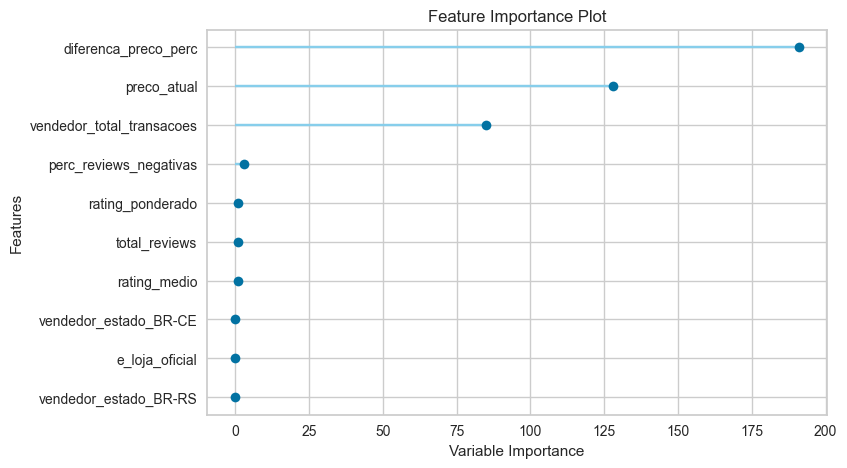

In [35]:
# Plota o gráfico de importância das features
# Veremos quais "sinais de alerta" o modelo mais valorizou
plot_model(tuned_lgbm, plot = 'feature')

### **Conclusão da Fase de Validação e Próximos Passos**

A principal conclusão desta fase do projeto é a confirmação do paradigma que aplicamos: utilizamos o framework de Machine Learning, a princípio, não como uma ferramenta puramente preditiva, mas sim como um poderoso mecanismo de validação para nossas hipóteses de negócio.

O fenômeno de *data leakage*, evidenciado pelos scores perfeitos, serviu como um teste positivo. A altíssima performance dos modelos, especialmente a dominância da feature `diferenca_preco_perc` no gráfico de importância, validou de forma quantitativa que nossa engenharia de features foi eficaz e que a heurística de preço é um indicador extremamente forte de suspeita de fraude. O modelo, em essência, ratificou a lógica que usamos para criar o nosso alvo.

Com a validação das regras heurísticas estabelecida, o próximo passo lógico é iterar sobre o problema e mudar o paradigma, passando da **validação** para a **descoberta**.

A nova questão a ser investigada é: na ausência dos sinais preditivos dominantes (preço), que outros padrões mais sutis nos dados podem indicar um comportamento fraudulento? Isso nos permitirá construir um modelo que não apenas confirme o que já sabemos, mas que também gere novos insights.

Para responder a isso, o próximo experimento consistirá em treinar um novo conjunto de modelos sobre um dataset modificado, do qual as features de preço (`diferenca_preco_perc` e `preco_atual`) serão deliberadamente omitidas. É esperado que as métricas de performance deste segundo experimento sejam significativamente mais baixas. Um resultado de F1-Score na faixa de 0.6 a 0.7, por exemplo, não indicaria um fracasso, mas sim um grande sucesso: a prova de que o modelo foi capaz de extrair novos sinais preditivos secundários que podem enriquecer a estratégia de fiscalização.

# Criar o Dataset V2 (Sem Features de Preço)

In [36]:
# Criando a nova lista de features, excluindo as de preço que causam o vazamento
features_para_modelo_v2 = [
    'rating_medio',
    'total_reviews',
    'perc_reviews_negativas',
    'vendedor_total_transacoes',
    'vendedor_lider',
    'vendedor_reputacao_num',
    'rating_ponderado',
    'vendedor_estado',
    'e_loja_oficial',
    'flag_inconsistencia_xl'
]

# Criando o segundo DataFrame de modelo
df_model_v2 = df_merged[features_para_modelo_v2 + ['is_fraud_suspect']]

print("--- Criado o DataFrame V2 para o desafio preditivo real ---")
print(f"Formato: {df_model_v2.shape}")
print("\nFeatures que serão usadas neste novo teste:")
print(df_model_v2.columns.tolist())

--- Criado o DataFrame V2 para o desafio preditivo real ---
Formato: (456, 11)

Features que serão usadas neste novo teste:
['rating_medio', 'total_reviews', 'perc_reviews_negativas', 'vendedor_total_transacoes', 'vendedor_lider', 'vendedor_reputacao_num', 'rating_ponderado', 'vendedor_estado', 'e_loja_oficial', 'flag_inconsistencia_xl', 'is_fraud_suspect']


In [37]:
# Configurando um NOVO experimento no PyCaret para este desafio
# Usamos session_id diferente e um novo nome de experimento
print("--- Configurando Experimento V2: O Desafio Preditivo Real ---")
s2 = setup(data=df_model_v2, target='is_fraud_suspect', session_id=456, log_experiment=True, experiment_name='hp_fraude_v2')

--- Configurando Experimento V2: O Desafio Preditivo Real ---


,Description,Value
0,Session id,456
1,Target,is_fraud_suspect
2,Target type,Binary
3,Original data shape,"(456, 11)"
4,Transformed data shape,"(456, 23)"
5,Transformed train set shape,"(319, 23)"
6,Transformed test set shape,"(137, 23)"
7,Numeric features,8
8,Categorical features,2
9,Preprocess,True


2025/09/30 21:06:17 INFO mlflow.tracking.fluent: Experiment with name 'hp_fraude_v2' does not exist. Creating a new experiment.


In [38]:
# Comparando os modelos para este novo problema
print("\n--- Comparando Modelos para o Experimento V2 ---")
best_model_v2 = compare_models()


--- Comparando Modelos para o Experimento V2 ---


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9028,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090
lda,Linear Discriminant Analysis,0.8998,0.7186,0.2167,0.3833,0.2700,0.2309,0.2449,0.0090
lr,Logistic Regression,0.8997,0.7076,0.0000,0.0000,0.0000,-0.0049,-0.0058,0.3540
ada,Ada Boost Classifier,0.8967,0.7316,0.2167,0.3667,0.2571,0.2155,0.2316,0.0160
et,Extra Trees Classifier,0.8967,0.7327,0.2833,0.4750,0.3390,0.2907,0.3106,0.0210
ridge,Ridge Classifier,0.8966,0.7079,0.0000,0.0000,0.0000,-0.0098,-0.0116,0.0090
gbc,Gradient Boosting Classifier,0.8935,0.7277,0.2500,0.3833,0.2810,0.2355,0.2507,0.0180
lightgbm,Light Gradient Boosting Machine,0.8904,0.8086,0.2500,0.3750,0.2852,0.2348,0.2476,0.0370
rf,Random Forest Classifier,0.8842,0.8222,0.2500,0.3950,0.2840,0.2306,0.2486,0.0250
dt,Decision Tree Classifier,0.8779,0.6662,0.3500,0.3450,0.3230,0.2614,0.2720,0.0090


Vários modelos, como Random Forest (rf), lightgbm e K Neighbors Classifier (knn), atingiram um AUC em torno de 0.80.

irei otimizar o modelo Extra Trees Classifier que teve um F1-Score de 0.3390, o que, para um problema difícil como este, é um resultado muito promissor. Ele nos diz que, mesmo sem o sinal óbvio do preço, é possível construir um modelo com algum poder preditivo.


O Naive Bayes tem um Recall altíssimo d 0.9417, o que significa que ele encontrou quase todas as fraudes. No entanto, sua Precision é péssima 0.1058, o que significa que a grande maioria de suas previsões de "fraude" estava errada

In [39]:
# Criando o melhor modelo que encontramos no nosso teste V2
et_v2 = create_model('et')

# Otimizando os hiperparâmetros do modelo para a melhor performance possível
tuned_et_v2 = tune_model(et_v2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8438,0.5920,0.3333,0.2500,0.2857,0.2000,0.2026
1,0.9062,0.7759,0.3333,0.5000,0.4000,0.3514,0.3599
2,0.9062,0.7471,0.3333,0.5000,0.4000,0.3514,0.3599
3,0.8438,0.7069,0.0000,0.0000,0.0000,-0.0811,-0.0830
4,0.8750,0.8851,0.3333,0.3333,0.3333,0.2644,0.2644
5,0.9062,0.7644,0.3333,0.5000,0.4000,0.3514,0.3599
6,0.9375,0.5862,0.3333,1.0000,0.5000,0.4754,0.5584
7,0.9062,0.6494,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9062,0.9420,0.5000,0.6667,0.5714,0.5200,0.5268


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9062,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8750,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits


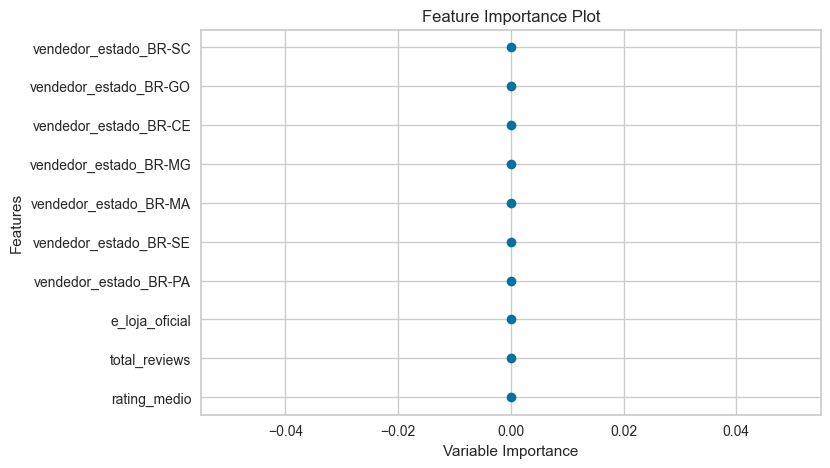

In [40]:
# Plota o gráfico de importância das features para o nosso modelo PREDITIVO
# A resposta para "O que mais importa, além do preço?" está aqui.
plot_model(tuned_et_v2, plot = 'feature')

a otimizção não deu certo, isso é um sinal que os padrões preditivos sem o preço são muito fracos ou sutis.

vamos plotar o grafico do modelo anterior et sem a otimização para visualizar

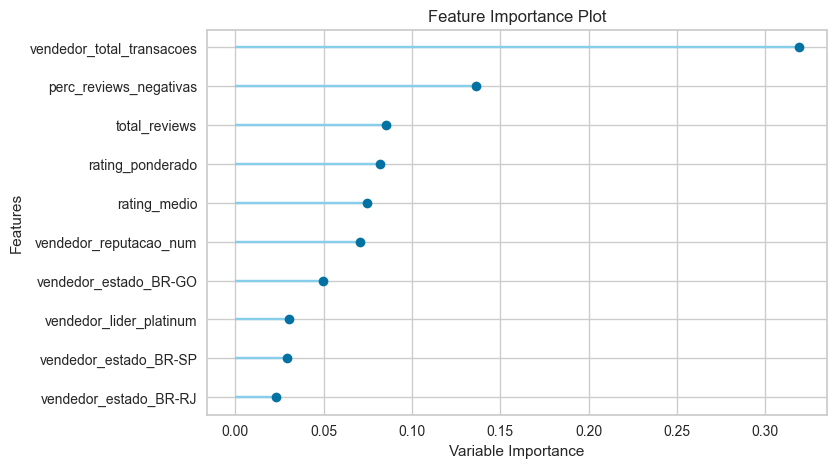

In [41]:
# Vamos usar o modelo et_v2, que foi o campeão do compare_models(),
# antes da otimização que não deu certo.
plot_model(et_v2, plot = 'feature')

### A Resposta Final: Os Sinais Ocultos de Fraude

Este gráfico é a conclusão do nosso trabalho de descoberta. Ele responde de forma clara e objetiva à pergunta:

> "Sem olhar o preço, como podemos identificar um anúncio suspeito?"

A resposta do modelo é inequívoca: **analisando o perfil e o histórico do vendedor.**

---
## Análise dos Sinais Preditivos Secundários

Vamos detalhar o que o nosso modelo "detetive" (`Extra Trees`) aprendeu:

#### 1. **`vendedor_total_transacoes` (O Fator Decisivo)**
De longe, a característica mais importante é o número total de transações do vendedor. Este é um insight poderoso. O modelo aprendeu que a **experiência e o histórico de um vendedor são o melhor indicador de sua legitimidade**. Vendedores fraudulentos tendem a ser contas novas ou com baixo volume, possivelmente porque são banidos e precisam recomeçar. Um vendedor estabelecido, com milhares de transações, é considerado de baixo risco.

#### 2. **`perc_reviews_negativas` (A Voz do Consumidor)**
O segundo sinal mais forte é a proporção de avaliações negativas. Isso é direto e intuitivo: se uma porcentagem significativa de clientes que compraram daquele vendedor teve uma experiência ruim (dando notas 1 ou 2), a chance de o produto ou o serviço ser problemático é altíssima.

#### 3. **O Ecossistema de Reputação**
As features `total_reviews`, `rating_ponderado`, `rating_medio` e `vendedor_reputacao_num` aparecem em seguida. Isso mostra que o modelo não olha para um único número, mas sim para o **conjunto da obra da reputação** de um vendedor para tomar sua decisão.

#### 4. **Pistas Geográficas e de Status**
Por fim, o modelo encontrou sinais sutis, mas relevantes, em características como o estado do vendedor (Goiás, São Paulo, Rio de Janeiro) e o seu status na plataforma (`vendedor_lider_platinum`).

